In [2]:
library(tidyverse)
ggplot2::theme_set(theme_bw())
library(showtext)
setwd("C:/Users/이찬솔/Documents/ADP/problem/problem2")

In [3]:
font_add_google(name = "Black Han Sans", family = "blackhansans")
showtext_auto()

# 1번
날씨 온도 예측, 종속변수 :actual(최고온도)   
데이터 출처 : https://towardsdatascience.com/random-forest-in-python-24d0893d51c0     
데이터 경로 : /kaggle/input/adp-kr-p2/problem1.csv    
temp_1 : 전날 최고온도    
temp_2 : 전전날 최고온도    
friend : 친구의 예측온도     



In [4]:
problem1 <- read.csv("problem1.csv")

### 1-1 데이터 확인 및 전처리
- 데이터 EDA 수행     
- 결측치를 확인하고 처리 방안에 대해 논의하라  
- 데이터 분할 방법 설명     
- 최종 데이터셋이 적절함을 주장하라     

In [6]:
library(lubridate)
library(gridExtra)

In [7]:
date <- make_date(problem1$year, problem1$month, problem1$day) 
length(date) ; nrow(gather(problem1 %>% select(-c(1:4))))

[1] 348

[1] 2784

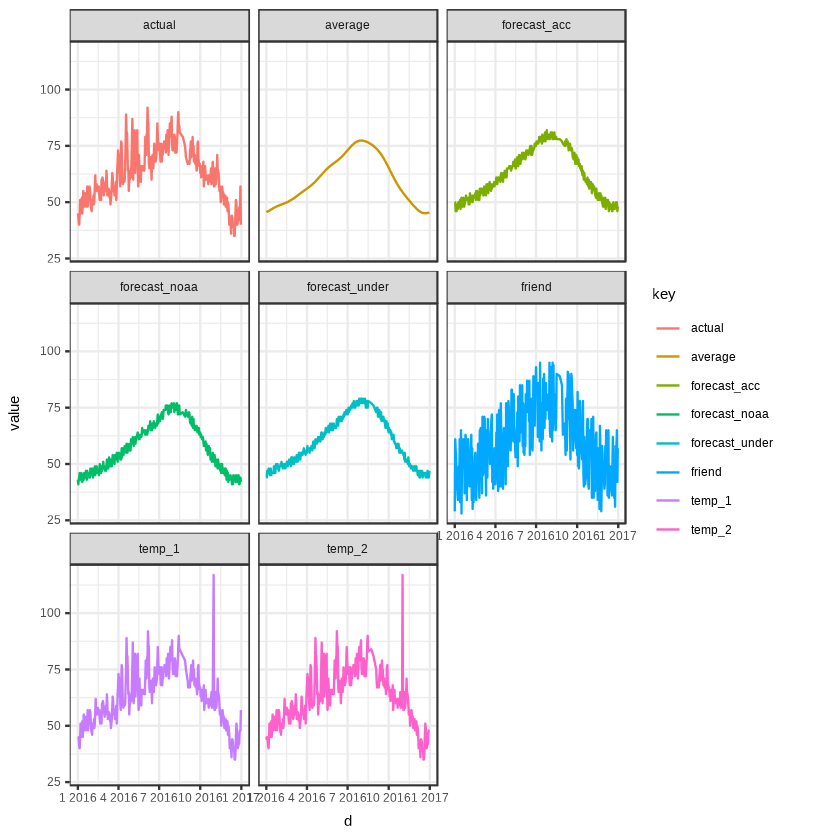

In [8]:
problem1 %>% select(-c(1:4)) %>%
    gather() %>% 
    mutate(d = rep(date, 8)) %>% 
    group_by(key, d) %>% 
    ggplot(aes(d, value, group = key, colour = key)) + geom_line() + 
    facet_wrap(~ key)

In [9]:
sum(is.na(problem1))
# colSums(is.na(problem1))

[1] 0

- 결측치 없음

In [67]:
caret::nearZeroVar(problem1, saveMetrics = TRUE) %>%
    tibble::rownames_to_column() %>%
    filter(nzv) 

rowname,freqRatio,percentUnique,zeroVar,nzv
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
year,0,0.2873563,TRUE,TRUE



- 모든 값이 2016으로 동일한 변수 "year"변수는 분산이 0에 가깝다는 점에, 제거가 필요

In [8]:
library(rsample)
library(caret)

In [12]:
data1 <- problem1 %>%
    mutate(week = as.factor(week) %>% as.numeric) %>%
    select(-year)

- 범주형 변수인 week을 수치형 변환
- 변수들의 단위가 상이함으로, 이에 따라 표준화 시행

In [29]:
library(recipes)

분할1
- 본 데이터는 2016년 한 해의 기간만 다루고 있기에, 12개월의 모든 데이터를 균등하게 학습하기 위해서, 구간을 분할 하는 것이 아닌 "month"변수의 비율을 유지하는 층화추출 방식을 통해 훈련데이터 / 평가데이터를 분할한다.

In [18]:
set.seed(1234)
split_1 <- initial_split(data2, strata = "month", prop = 0.7)
train_1 <- training(split_1)
test_1 <- testing(split_1)

분할2
- 일반적인 시계열 데이터 분할 방법

In [15]:
data2 <- recipe(~., data = data1 %>% select(-actual)) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric()) %>%
    prep(training = data1 %>% select(-actual), retain = TRUE) %>%
    juice() %>%
    mutate(actual = data1$actual)

In [16]:
data3 <- data2 %>% mutate(date = date) 

In [17]:
set.seed(1234)
split_2 <- initial_time_split(data3, prop = 0.7)
train_2 <- training(split_2) %>% select(-date)
test_2 <- testing(split_2) %>% select(-date)

### 1-2 Random Forest 모델 적합 및 검증   
- Random Forest 학습 및 예측 결과 해석    
- 예측 결과 검정 해석, 중요변수 도출    
- 변수 중요성 분석 및 그래프 출력     

In [193]:
n_features <- ncol(data1) - 1

In [194]:
library(ranger)

In [195]:
hyper_grid <- expand.grid(
    num.trees = c(500, 1000, 1500),
    mtry = floor(n_features * c(0.15, 0.25, 0.333, 0.4)),
    min.node.size = c(1, 3, 5, 10),
    rmse = NA
)

In [196]:
for (i in seq_len(nrow(hyper_grid))) {
    fit <- ranger(
        formula = actual ~ .,
        data = train_1,
        num.trees = hyper_grid$num.trees[i],
        mtry = hyper_grid$mtry[i],
        min.node.size = hyper_grid$min.node.size[i],
        verbose = FALSE,
        seed = 1234
    )
    hyper_grid$rmse[i] <- sqrt(fit$prediction.error)
}

In [197]:
hyper_grid %>% arrange(rmse) %>% head(1)

,num.trees,mtry,min.node.size,rmse
,<dbl>,<dbl>,<dbl>,<dbl>
1,1000,3,5,4.914121


In [165]:
cv_rf <- ranger(
    actual ~ .,
    data = train_1,
    mtry = 3,
    num.trees = 1000,
    min.node.size = 5,
    importance = "impurity",
    seed = 1234
)

In [91]:
# cv_rf

- 그리드 서치를 통해 탐색한 하이퍼 파라미터는 ~ 이다.
- 그리드 서치를 통해 생성한 최종 랜덤포레스트 모형의 R squred 값은 ~ 이며, OOB MSE는 ~ 이다.

In [92]:
imp <- ranger::importance(cv_rf)

In [ ]:
data.frame(imp, vars = names(imp)) %>% 
    ggplot(aes(fct_reorder(vars, imp), imp)) + 
    geom_col() + coord_flip()

- 랜덤 포레스트 생성 트리의 노드 불순도 개선에 가장 많은 기여한 가장 중요변수는 "temp1", "average"이며, 나머지를 뒤따른다.

In [166]:
rf_pred <- predict(cv_rf, test_1)

In [167]:
library(MLmetrics)
RMSE(rf_pred$predictions, test_1$actual)
MSE(rf_pred$predictions, test_1$actual)

[1] 5.084734

[1] 25.85452

In [155]:
rf_pred <- predict(cv_rf, test_2)

In [156]:
library(MLmetrics)
RMSE(rf_pred$predictions, test_2$actual)
MSE(rf_pred$predictions, test_2$actual)

[1] 5.797308

[1] 33.60878

### 1-3 SVM(Support Vector Machine) 모델 적합 및 검증  
- SVM 학습 및 예측 결과 해석    
- 예측 결과 검정 해석, 중요변수 도출    
- 변수 중요성 분석 및 그래프 출력     

In [137]:
library(caret)

In [168]:
hyper_grid <- expand.grid(
    C = c(0.01, 0.1, 0.5, 1, 10, 100)
)

In [169]:
set.seed(1234)
svm_cv1 <- train(
    actual ~ .,
    data = train_1,
    method = "svmLinear", 
    # "svmRadial" (Cost, sigma) / "svmPoly" (Polynomial Degree, Scale, Cost)
    # metric = "ROC", "accuracy"
    trControl = trainControl(method = "cv", number = 10),
    tuneGrid = hyper_grid
)

In [170]:
svm_cv1$bestTune

,C
,<dbl>
2,0.1


In [142]:
# svm_cv1

- 그리드 서치를 통해 탐색한 하이퍼 파라미터는 ~ 이다.
- 그리드 서치를 통해 생성한 최종 SVM 모형의 R squred 값은 ~ 이며, OOB MSE는 ~ 이다.

In [198]:
svm_mod <- train(
    actual ~ .,
    data = train_1,
    method = "svmLinear",
    Cost = 0.1
)

In [199]:
svm_pred <- predict(svm_mod, test_1)
RMSE(svm_pred, test_1$actual)
MSE(svm_pred, test_1$actual)

[1] 5.006148

[1] 25.06151

In [161]:
svm_pred <- predict(svm_mod, test_2)
RMSE(svm_pred, test_2$actual)
MSE(svm_pred, test_2$actual)

[1] 5.505024

[1] 30.30529

In [ ]:
ggplot(caret::varImp(svm_mod, scale = T))

-  생성된 SVM 모형의 중요변수는 "temp1", "average"이며, 나머지를 뒤따른다.

### 1-4 모델 비교 및 향후 개선 방향 도출
- Random Forest, SVM 모델의 결과 비교 후 최종 모델 선택    
- 두 모델의 장단점 분석, 추후 운영 관점에서 어떤 모델을 선택할 것인가?    
- 모델링 관련 추후 개선 방향 제시     

# 2번 
5분간격의 가구별 전력 사용량의 데이터    
데이터 출처 : 자체생성    
데이터 경로 : /kaggle/input/adp-kr-p2/problem2.csv    

In [4]:
problem2 <- read.csv("problem2.csv")
sum(is.na(problem2))

[1] 0

### 2-1 데이터 전처리
각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라.    
군집화를 위한 데이터 구성의 이유를 설명하라    
(군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)

<img src = "https://github.com/Datamanim/datarepo/blob/main/adp/p2/problem2.png?raw=true">

In [9]:
problem2$date <- as_datetime(problem2$date)

In [10]:
problem2_1 <- problem2 %>%
    mutate(year = year(date),
           mon = month(date),
           day = day(date),
           hour = hour(date),
           min = minute(date),
           sec = second(date)) %>% 
    arrange(date) %>%
    select(-date) %>%
    mutate(houseCode = as.factor(houseCode)) 

In [11]:
problem2_2 <- problem2_1 %>%
    mutate(min1 = ifelse(min %in% c(0, 5, 10), "15",
                         ifelse(min %in% c(15, 20, 25), "30",
                                ifelse(min %in% c(30, 35, 40), "45", "60"))) %>%
              as.numeric())

In [12]:
problem2_3 <- problem2_2 %>%
    mutate(date = make_datetime(year, mon, day, hour, min1, sec) - minutes(15)) %>%
    select(-c(year, mon, day, hour, min, min1, sec)) %>%
    arrange(date) 

In [13]:
problem2_4 <- problem2_3 %>%
    group_by(houseCode, date) %>% 
    summarise(power.consumption.sum = sum(power.consumption)) %>%
    ungroup()

`summarise()` has grouped output by 'houseCode'. You can override using the `.groups` argument.


In [37]:
problem2_4 %>% tail

houseCode,date,power.consumption.sum
<fct>,<dttm>,<dbl>
house_44,2050-01-31 22:30:00,216.7375
house_44,2050-01-31 22:45:00,334.6757
house_44,2050-01-31 23:00:00,463.4199
house_44,2050-01-31 23:15:00,369.9307
house_44,2050-01-31 23:30:00,237.7130
house_44,2050-01-31 23:45:00,184.8884


In [160]:
problem2_k <- problem2_4 %>%
    mutate(mday = day(date),
           hour = hour(date),
           min = minute(date),
           wday = wday(date)) %>%
    select(-date)  

군집화를 위한 데이터 구성의 이유
- 날짜(date)의 시간 단위별로 관측값 간의 거리를 이용하여 군집화 하기 위해 date변수를 파싱
- 단일값을 가지는 연/월/초에 대한 변수를 제거
- houseCode변수를 군집화를 위하여 수치형으로 변환 (원-핫 인코딩)
- 밀도기반 군집화는 변수의 단위가 결과에 비교적 덜 영향을 미침, 따라서 표준화 적용 X

In [163]:
mc <- recipe(~., data = problem2_k) %>%
    step_dummy(all_nominal(), one_hot = TRUE) %>%
    prep(training = problem2_k, reatin = TRUE) %>%
    juice()

In [149]:
library(cluster)
library(factoextra)
library(kernlab)
library(mclust)

In [165]:
set.seed(1234)
mcm <- mclust::Mclust(mcm, G = 5)

In [166]:
final <- problem2_4 %>%
    mutate(Cluster = mcm$classification) %>%
    select(houseCode, date, power.consumption.sum, Cluster)

In [167]:
final %>% head

houseCode,date,power.consumption.sum,Cluster
<fct>,<dttm>,<dbl>,<dbl>
house_00,2050-01-01 00:00:00,136.24995,3
house_00,2050-01-01 00:15:00,98.28339,3
house_00,2050-01-01 00:30:00,53.96768,3
house_00,2050-01-01 00:45:00,204.82127,5
house_00,2050-01-01 01:00:00,150.76079,5
house_00,2050-01-01 01:15:00,106.75916,3


### 2-2 히트맵
2-1의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라    
(수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)     
<img src = "https://github.com/Datamanim/datarepo/blob/main/adp/p2/problem2_Example.png?raw=true">

In [168]:
final2 <- final %>%
    mutate(hm = format(date, "%H:%M"),
           wday = wday(date, label = T, week_start = 1))

In [169]:
levels(final2$wday)

[1] "월" "화" "수" "목" "금" "토" "일"

In [170]:
(levels(final2$wday) <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                         "Saturday", "Sunday"))

[1] "Monday"    "Tuesday"   "Wednesday" "Thursday"  "Friday"    "Saturday" 
[7] "Sunday"

In [171]:
rev(levels(final2$wday))

[1] "Sunday"    "Saturday"  "Friday"    "Thursday"  "Wednesday" "Tuesday"  
[7] "Monday"

In [172]:
library(viridis)

`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.


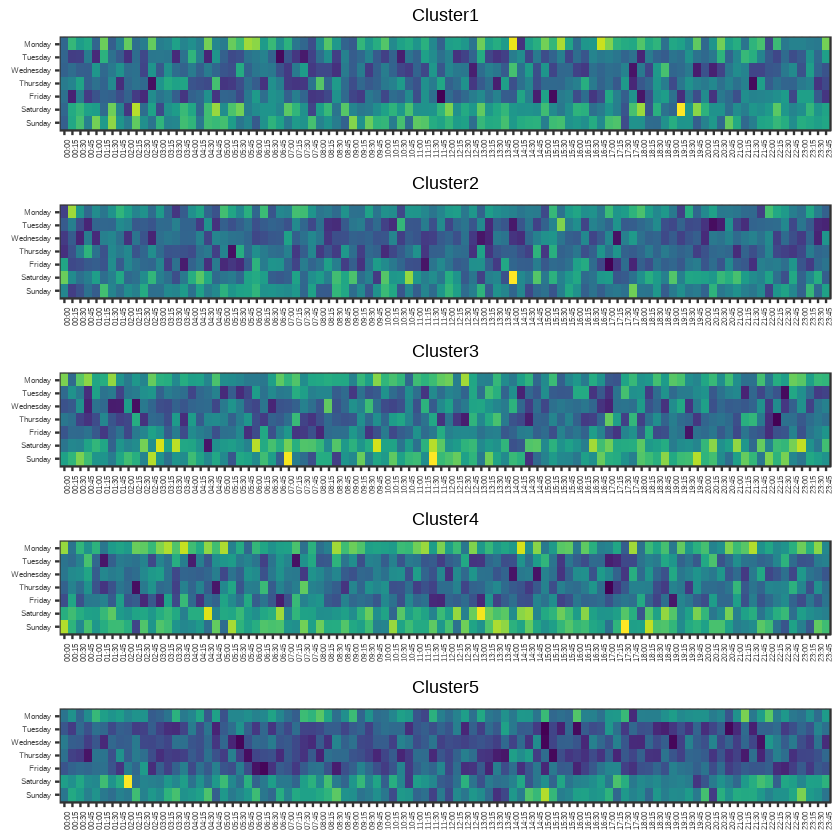

In [174]:
p1 <- final2 %>% filter(Cluster == 1) %>%
    group_by(wday, hm) %>%
    summarise(sum = sum(power.consumption.sum)) %>% 
    ggplot(aes(hm, fct_relevel(wday, rev(levels(final2$wday))), fill = sum)) + 
    geom_tile() +
    ggtitle("Cluster1") + 
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 90, size = 6),
          axis.text.y = element_text(size = 6),
          axis.title = element_blank(),
          plot.title = element_text(hjust = 0.5)) + 
    scale_fill_viridis(discrete = F)
    # scale_fill_distiller (분홍) / scale_fill_gradient (연보라)
# p2 <- 
# p3 <- 
# p4 <-
# p5 <-
gridExtra::grid.arrange(grobs = list(p1, p2, p3, p4, p5), nrow = 5)

In [16]:
d1 <- "January 1, 2010" ; d2 <- "2015-Mar-07" ; d3 <- "06-Jun-2017" ; d4 <- c("August 19 (2015)", "July 1 (2015)") ; d5 <- "12/30/14"
mdy(d1) 
# ymd(d2) ; dmy(d3) ; mdy(d4) ; mdy(d5)

[1] "2010-01-20"

# 3번 태양광 데이터
예측 변수 :SOLAR PV

데이터 경로 : /kaggle/input/adp-kr-p2/problem3.csv    
데이터 출처 : https://www.kaggle.com/cheedcheed/california-renewable-production-20102018

In [8]:
problem3 <- read.csv("problem3.csv")
sum(is.na(problem3))

[1] 44904

### 3-1
**데이터셋 분할 및 결과 검증**    
- 데이터셋 7:3 분할    
- 데이터 전처리 및 예측 모델 생성    
- 모델 성능 검증 : RMSE, R제곱, 정확도(아래 방식으로 연산)로 구하여라    
- 정확도의 경우 실제값>예측값인 경우 (1-예측값/실제값), 실제값<예측값인 경우 (1- 실제값/예측값)으로 하고 이것들을 평균낸 후 1에서 뺀값으로 한다.   
  분수식의 분모가 0인 경우의 정확도는 0.5로 취급한다.

- 최종 결과 제출 : 소수점 3째자리 반올림     

In [9]:
problem31 <- problem3 %>% select(-SOLAR)
problem31$TIMESTAMP <- as_datetime(problem31$TIMESTAMP)

- 시간형 변수 파싱

In [10]:
problem32 <- problem31 %>%
    mutate(year = year(TIMESTAMP),
           month = month(TIMESTAMP),
           day = day(TIMESTAMP),
           hour = hour(TIMESTAMP)) %>%
    select(-c("Hour", "TIMESTAMP"))

- 분산이 0인 변수 제거
- 단위가 변수마다 상이함으로 표준화

In [11]:
caret::nearZeroVar(problem32, saveMetrics = TRUE) %>%
    tibble::rownames_to_column() %>%
    filter(nzv) 

rowname,freqRatio,percentUnique,zeroVar,nzv
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
SOLAR.THERMAL,155.9527,1.607875,FALSE,TRUE


In [13]:
library(recipes)
problem33 <- recipe( ~ ., data = problem32) %>%
    step_rm(SOLAR.PV) %>%
    step_nzv(all_nominal()) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric()) %>%
    prep(training = problem32, retain = TRUE) %>%
    juice() %>%
    mutate(SOLAR.PV = problem32$SOLAR.PV)

- year변수의 비율의 다소 불균형하기에 층화추출로 비율을 유지한채 데이터 셋 7:3 분할

In [14]:
set.seed(1234)
split_1 <- rsample::initial_time_split(problem33, prop = 0.7)
train_1 <- training(split_1) 
test_1 <- testing(split_1) 

In [16]:
library(glmnet)
library(caret)

In [18]:
train_y <- train_1$SOLAR.PV
train_x <- model.matrix(SOLAR.PV ~ ., train_1)[, -1]

In [19]:
test_y <- test_1$SOLAR.PV
test_x <- model.matrix(SOLAR.PV ~ ., test_1)[, -1]

In [20]:
cv_glmnet <- train(
    x = train_x,
    y = train_y,
    method = "glmnet",
    trControl = trainControl(method = "cv", number = 10),
    tuneLength = 10
)

In [21]:
cv_glmnet$bestTune

,alpha,lambda
,<dbl>,<dbl>
55,0.7,1.558992


In [22]:
cv_glmnet$results %>%
    filter(alpha == cv_glmnet$bestTune$alpha,
           lambda == cv_glmnet$bestTune$lambda)

alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7,1.558992,947.9907,0.7173596,690.0895,17.21098,0.010604,9.5858


In [23]:
cv_final <- glmnet(x = train_x, y = train_y,
                   alpha = cv_glmnet$bestTune$alpha,
                   lambda = cv_glmnet$bestTune$lambda)

In [24]:
glm_pred <- glmnet::predict.glmnet(object = cv_final, newx = test_x)

In [30]:
library(MLmetrics)

In [28]:
MLmetrics::RMSE(glm_pred, test_y)
MLmetrics::R2_Score(glm_pred, test_y)

[1] 2072.409

[1] 0.585769

In [30]:
ACC <- function(pred, actual) {
    acc <- c()
    for (i in 1:length(pred)) {
        if (pred[i] < actual[i]) {
            if (actual[i] == 0) {
                acc[i] = 0.5
            } else if (actual[i] != 0) {
                acc[i] = 1 - (pred[i] / actual[i])
            }
        }
        else {
            acc[i] = 1 - (actual[i] / pred[i])
        }
    }
    return (1 - mean(acc))
}

In [37]:
ACC(glm_pred, test_y)

[1] 0.2909081

In [19]:
library(pls)

In [20]:
set.seed(1234)
pcr.fit <- pcr(SOLAR.PV ~ ., data = problem33, subset = 1:nrow(train_1),
               validation = "CV")

In [26]:
pcr.pred <- predict(pcr.fit,
                    newdata = problem33[(nrow(train_1)+1):nrow(problem33),],
                    ncomp = 10)

In [31]:
MLmetrics::RMSE(pcr.pred, test_1$SOLAR.PV)
MLmetrics::R2_Score(pcr.pred, test_1$SOLAR.PV)
ACC(pcr.pred, test_1$SOLAR.PV)

[1] 2070.696

[1] 0.5864537

[1] 0.2913963